<font size="+3"><strong>Predicting Price with Neighborhood</strong></font>

In [2]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wqet_grader
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)
wqet_grader.init("Project 2 Assessment")

In the last lesson, we created a model that used location — represented by latitude and longitude — to predict price. In this lesson, we're going to use a different representation for location: neighborhood. 

In [147]:
VimeoVideo("656790491", h="6325554e55", width=600)

# Prepare Data

## Import

In [148]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    #Extract neighborhood
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)


    return df

In the last lesson, we used our `wrangle` function to import two CSV files as DataFrames. But what if we had hundreds of CSV files to import? Wrangling them one-by-one wouldn't be an option. So let's start with a technique for reading several CSV files into a single DataFrame. 

The first step is to gather the names of all the files we want to import. We can do this using pattern matching. 

In [149]:
VimeoVideo("656790237", h="1502e3765a", width=600)

**Task 2.3.1:** Use [`glob`](https://docs.python.org/3/library/glob.html#glob.glob) to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the `data` directory. Assign this list to the variable name `files`.

- [<span id='technique'>Assemble a list of path names that match a pattern in <span id='tool'>glob.](../%40textbook/02-python-advanced.ipynb#Working-with-strings-)

In [150]:
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data/buenos-aires-real-estate-1.csv',
 'data/buenos-aires-real-estate-4.csv',
 'data/buenos-aires-real-estate-5.csv',
 'data/buenos-aires-real-estate-3.csv',
 'data/buenos-aires-real-estate-2.csv']

In [151]:
# Check your work
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

The next step is to read each of the CSVs in `files` into a DataFrame, and put all of those DataFrames into a list. What's a good way to iterate through `files` so we can do this? A `for` loop!

In [152]:
VimeoVideo("656789768", h="3b8f3bca0b", width=600)

**Task 2.3.2:** Use your `wrangle` function in a `for` loop to create a list named `frames`. The list should the cleaned DataFrames created from the CSV filenames your collected in `files`.

- [What's a <span id='term'>for loop</span>?](../%40textbook/01-python-getting-started.ipynb#Python-for-Loops)
- [<span id='technique'>Write a for loop in <span id='tool'>Python.](../%40textbook/01-python-getting-started.ipynb#Working-with-for-Loops)

In [153]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)

In [154]:
# Check your work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

The final step is to use pandas to combine all the DataFrames in `frames`. 

In [155]:
VimeoVideo("656789700", h="57adef4afe", width=600)

**Task 2.3.3:** Use [`pd.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concatenate the items in `frames` into a single DataFrame `df`. Make sure you set the `ignore_index` argument to `True`.

- [<span id='technique'>Concatenate two or more DataFrames using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Concatenating-DataFrames)

In [156]:
df = pd.concat(frames, ignore_index=True)
df.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


In [157]:
# Check your work
assert len(df) == 6582, f"`df` is the wrong size: {len(df)}."

Excellent work! You can now clean and combine as many CSV files as your computer can handle. You're well on your way to working with big data. 📈

## Explore

Looking through the output from the `df.head()` call above, there's a little bit more cleaning we need to do before we can work with the neighborhood information in this dataset. The good news is that, because we're using a `wrangle` function, we only need to change the function to re-clean all of our CSV files. This is why functions are so useful.

In [3]:
VimeoVideo("656791659", h="581201dc92", width=600)

**Task 2.3.4:** Modify your `wrangle` function to create a new feature `"neighborhood"`. You can find the neighborhood for each property in the `"place_with_parent_names"` column. For example, a property with the place name `"|Argentina|Capital Federal|Palermo|"` is located in the neighborhood is `"Palermo"`. Also, your function should drop the `"place_with_parent_names"` column.

Be sure to rerun all the cells above before you continue.

- [<span id='technique'>Split the strings in one column to create another using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Splitting-Strings)

In [159]:
# Check your work
assert df.shape == (6582, 17), f"`df` is the wrong size: {df.shape}."
assert (
    "place_with_parent_names" not in df
), 'Remember to remove the `"place_with_parent_names"` column.'

## Split

At this point, you should feel more comfortable with the splitting data, so we're going to condense the whole process down to one task. 

In [160]:
VimeoVideo("656791577", h="0ceb5341f8", width=600)

**Task 2.3.5:** Create your feature matrix `X_train` and target vector `y_train`. `X_train` should contain one feature: `"neighborhood"`. Your target is `"price_aprox_usd"`. 

- [What's a <span id='term'>feature matrix?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [What's a <span id='term'>target vector?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [<span id='technique'>Subset a DataFrame by selecting one or more columns in <span id='tool'>pandas.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns) 
- [<span id='technique'>Select a Series from a DataFrame in <span id='tool'>pandas.](../%40textbook/04-pandas-advanced.ipynb#Select-a-Series-from-a-DataFrame) 

In [161]:
target = "price_aprox_usd"
features = ["neighborhood"]
y_train = df[target]
X_train = df[features]

In [162]:
# Check your work
assert X_train.shape == (6582, 1), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

# Build Model

## Baseline

Let's also condense the code we use to establish our baseline. 

In [163]:
VimeoVideo("656791443", h="120a740cc3", width=600)

**Task 2.3.6:** Calculate the baseline mean absolute error for your model.

- [<span id='term'>What's a performance metric?](../%40textbook/12-ml-core.ipynb#Performance-Metrics)
- [<span id='term'>What's mean absolute error?](../%40textbook/12-ml-core.ipynb#Performance-Metrics)
- [<span id='technique'>Calculate summary statistics for a DataFrame or Series in <span id='tool'>pandas.](../%40textbook/05-pandas-summary-statistics.ipynb#Working-with-Summary-Statistics)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [164]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] *len(y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458536
Baseline MAE: 44860.108342741354


The mean apartment price and baseline MAE should be similar but not identical to last lesson. The numbers will change since we're working with more data.

## Iterate

If you try to fit a `LinearRegression` predictor to your training data at this point, you'll get an error that looks like this:

```
ValueError: could not convert string to float
```

What does this mean? When you fit a linear regression model, you're asking scikit-learn to perform a mathematical operation. The problem is that our training set contains neighborhood information in non-numerical form. In order to create our model we need to **encode** that information so that it's represented numerically. The good news is that there are lots of transformers that can do this. Here, we'll use the one from the [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html) library, called a [`OneHotEncoder`](https://contrib.scikit-learn.org/category_encoders/onehot.html).

Before we build include this transformer in our pipeline, let's explore how it works. 

In [165]:
VimeoVideo("656792790", h="4097efb40d", width=600)

**Task 2.3.7:** First, instantiate a `OneHotEncoder` named `ohe`. Make sure to set the `use_cat_names` argument to `True`. Next, fit your transformer to the feature matrix `X_train`. Finally, use your encoder to transform the feature matrix `X_train`, and assign the transformed data to the variable `XT_train`.

- [What's <span id='term'>one-hot encoding?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)
- [<span id='technique'>Instantiate a transformer in <span id='tool'>scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)
- [<span id='technique'>Fit a transformer to training data in <span id='tool'>scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)
- [<span id='technique'>Transform data using a transformer in <span id='tool'>scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#One-Hot-Encoding)

In [166]:
# Instantiate
ohe = OneHotEncoder(use_cat_names=True)
# Fit
ohe.fit(X_train)
# Transform
XT_train = ohe.transform(X_train)
print(XT_train.shape)
XT_train.head()

(6582, 57)


,neighborhood_Chacarita,neighborhood_Villa Luro,neighborhood_Caballito,neighborhood_Constitución,neighborhood_Once,neighborhood_Almagro,neighborhood_Palermo,neighborhood_Flores,neighborhood_Belgrano,neighborhood_Liniers,...,neighborhood_Puerto Madero,neighborhood_Agronomía,neighborhood_Monte Castro,neighborhood_Tribunales,neighborhood_Villa Santa Rita,neighborhood_Velez Sarsfield,neighborhood_Villa Soldati,neighborhood_Villa Real,neighborhood_Pompeya,neighborhood_Catalinas
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
# Check your work
assert XT_train.shape == (6582, 57), f"`XT_train` is the wrong shape: {XT_train.shape}"

Now that we have an idea for how the `OneHotEncoder` works, let's bring it into our pipeline.

In [168]:
VimeoVideo("656792622", h="0b9d189e8f", width=600)

**Task 2.3.8:** Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LinearRegression` predictor. Then fit your model to the training data. 

- [What's a <span id='term'>pipeline?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#scikit-learn-in-Production)
- [<span id='technique'>Create a pipeline in <span id='tool'>scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Creating-a-Pipeline-in-scikit-learn)

In [169]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('ridge', Ridge())])

In [170]:
# Check your work
check_is_fitted(model[-1])

Wow, you just built a model with two transformers and a predictor! When you started this course, did you think you'd be able to do something like that? 😁

## Evaluate

Regardless of how you build your model, the evaluation step stays the same. Let's see how our model performs with the training set.

In [171]:
VimeoVideo("656792525", h="09edc1c3d6", width=600)

**Task 2.3.9:** First, create a list of predictions for the observations in your feature matrix `X_train`. Name this list `y_pred_training`. Then calculate the training mean absolute error for your predictions in `y_pred_training` as compared to the true targets in `y_train`.

- [<span id='technique'>Generate predictions using a trained model in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Generating-Predictions-Using-a-Trained-Model)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [172]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 39350.22


Now let's check our test performance. 

**Task 2.3.10:** Run the code below to import your test data `buenos-aires-test-features.csv` into a DataFrame and generate a Series of predictions using your model. Then run the following cell to submit your predictions to the grader.

- [What's generalizability?](../%40textbook/12-ml-core.ipynb#Generalization)
- [<span id='technique'>Generate predictions using a trained model in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Generating-Predictions-Using-a-Trained-Model)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [173]:
X_test = pd.read_csv("data/buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    246624.694624
1    161355.968734
2     98232.051308
3    110846.030377
4    127777.538197
dtype: float64

In [174]:
wqet_grader.grade("Project 2 Assessment", "Task 2.3.10", y_pred_test)

# Communicate Results

If we write out the equation for our model, it'll be too big to fit on the screen. That's because, when we used the `OneHotEncoder` to encode the neighborhood data, we created a much wider DataFrame, and each column/feature has it's own coefficient in our model's equation.

<center><img src="../images/proj-2.006.png" alt="Equation: y = β0 + β1 x1 + β2 x2 + ... + β59 x59 + β60 x60 " style="width: 800px;"/></center>

This is important to keep in mind for two reasons. First, it means that this is a **high-dimensional** model. Instead of a 2D or 3D plot, we'd need a 58-dimensional plot to represent it, which is impossible! Second, it means that we'll need to extract and represent the information for our equation a little differently than before. Let's start by getting our intercept and coefficient.

In [175]:
VimeoVideo("656793909", h="fca67856b4", width=600)

**Task 2.3.11:** Extract the intercept and coefficients for your model. 

- [What's an <span id='term'>intercept</span> in a linear model?](../%40textbook/12-ml-core.ipynb#Model-Types)
- [What's a <span id='term'>coefficient</span> in a linear model?](../%40textbook/12-ml-core.ipynb#Model-Types)
- [<span id='technique'>Access an object in a pipeline in <span id='tool'>scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)

In [176]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 57
[-2.89895934e+03 -6.29555347e+00  9.25289088e+03 -4.17487330e+04
 -3.23037446e+03]


In [177]:
# Check your work
assert isinstance(
    intercept, float
), f"`intercept` should be a `float`, not {type(intercept)}."
assert isinstance(
    coefficients, np.ndarray
), f"`coefficients` should be a `float`, not {type(coefficients)}."
assert coefficients.shape == (
    57,
), f"`coefficients` is wrong shape: {coefficients.shape}."

We have the values of our coefficients, but how do we know which features they belong to? We'll need to get that information by going into the part of our pipeline that did the encoding.

In [178]:
VimeoVideo("656793812", h="810161b84e", width=600)

**Task 2.3.12:** Extract the feature names of your encoded data from the `OneHotEncoder` in your model.

- [Access an object in a pipeline in scikit-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Accessing-an-Object-in-a-Pipeline)

In [179]:
feature_names = model.named_steps["onehotencoder"].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 57
['neighborhood_Chacarita', 'neighborhood_Villa Luro', 'neighborhood_Caballito', 'neighborhood_Constitución', 'neighborhood_Once']


In [180]:
# Check your work
assert isinstance(
    feature_names, list
), f"`features` should be a `list`, not {type(features)}."
assert len(feature_names) == len(
    coefficients
), "You should have the same number of features and coefficients."

We have coefficients and feature names, and now we need to put them together. For that, we'll use a Series.

In [181]:
VimeoVideo("656793718", h="1e2a1e1de8", width=600)

**Task 2.3.13:** Create a pandas Series named `feat_imp` where the index is your `features` and the values are your `coefficients`.

- [<span id='technique'>Create a Series in <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-Columns)

In [182]:
feat_imp = pd.Series(coefficients, index=feature_names)
feat_imp.head()

neighborhood_Chacarita       -2898.959335
neighborhood_Villa Luro         -6.295553
neighborhood_Caballito        9252.890876
neighborhood_Constitución   -41748.733031
neighborhood_Once            -3230.374461
dtype: float64

In [183]:
# Check your work
assert isinstance(
    feat_imp, pd.Series
), f"`feat_imp` should be a `float`, not {type(feat_imp)}."
assert feat_imp.shape == (57,), f"`feat_imp` is wrong shape: {feat_imp.shape}."
assert all(
    a == b for a, b in zip(sorted(feature_names), sorted(feat_imp.index))
), "The index of `feat_imp` should be identical to `features`."

To be clear, it's definitely not a good idea to show this long equation to an audience, but let's print it out just to check our work. Since there are so many terms to print, we'll use a `for` loop.

In [184]:
VimeoVideo("656797021", h="dc90e6dac3", width=600)

**Task 2.3.14:** Run the cell below to print the equation that your model has determined for predicting apartment price based on longitude and latitude.

- [What's an f-string?](../%40textbook/02-python-advanced.ipynb#Working-with-f-strings-)

In [185]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = 118524.65
+ (-2898.96 * neighborhood_Chacarita)
+ (-6.3 * neighborhood_Villa Luro)
+ (9252.89 * neighborhood_Caballito)
+ (-41748.73 * neighborhood_Constitución)
+ (-3230.37 * neighborhood_Once)
+ (2903.34 * neighborhood_Almagro)
+ (45934.41 * neighborhood_Palermo)
+ (-8662.28 * neighborhood_Flores)
+ (46954.21 * neighborhood_Belgrano)
+ (-13729.1 * neighborhood_Liniers)
+ (6277.05 * neighborhood_Villa Crespo)
+ (-10678.63 * neighborhood_San Cristobal)
+ (-7974.66 * neighborhood_Congreso)
+ (14701.16 * neighborhood_Saavedra)
+ (-11172.55 * neighborhood_Balvanera)
+ (-29585.61 * neighborhood_Parque Avellaneda)
+ (72740.78 * neighborhood_Recoleta)
+ (5638.47 * neighborhood_San Telmo)
+ (42831.32 * neighborhood_Nuñez)
+ (55590.93 * neighborhood_Barrio Norte)
+ (-6323.68 * neighborhood_Parque Centenario)
+ (4330.55 * neighborhood_Abasto)
+ (-7905.29 * neighborhood_Centro / Microcentro)
+ (-19370.74 * neighborhood_)
+ (-7108.23 * neighborhood_Paternal)
+ (-21078.78 * neighborhood_Ma

<div class="alert alert-block alert-warning">
<b>Warning:</b> In the first lesson for this project, we said that you shouldn't make any changes to your model after you see your test metrics. That's still true. However, we're breaking that rule here so that we can discuss overfitting. In future lessons, you'll learn how to protect against overfitting without checking your test set.
</div>

In [186]:
VimeoVideo("656799309", h="a7130deb64", width=600)

**Task 2.3.15:** Scroll up, change the predictor in your model to `Ridge`, and retrain it. Then evaluate the model's training and test performance. Do you still have an overfitting problem? If not, extract the intercept and coefficients again (you'll need to change your code a little bit) and regenerate the model's equation. Does it look different than before?

- What's <span id='term'>overfitting?
- What's <span id='term'>regularization?
- What's <span id='term'>ridge regression?

In [187]:
# Check your work
assert isinstance(
    model[-1], Ridge
), "Did you retrain your model using a `Ridge` predictor?"

We're back on track with our model, so let's create a visualization that will help a non-technical audience understand what the most important features for our model in predicting apartment price. 

In [188]:
VimeoVideo("656798530", h="9a9350eff1", width=600)

**Task 2.3.16:** Create a horizontal bar chart that shows the top 15 coefficients for your model, based on their absolute value.

- [What's a <span id='term'>bar chart</span>?](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)
- [<span id='technique'>Create a bar chart using <span id='tool'>pandas</span></span>.](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)

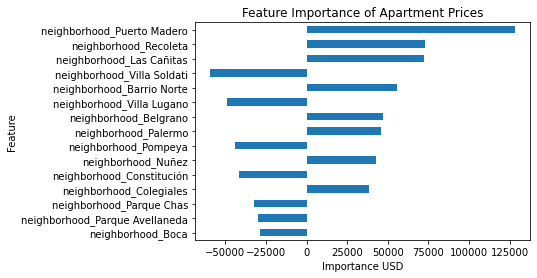

In [192]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance USD")
plt.ylabel("Feature")
plt.title("Feature Importance of Apartment Prices");

Looking at this bar chart, we can see that the poshest neighborhoods in Buenos Aires like [Puerto Madero](https://en.wikipedia.org/wiki/Puerto_Madero) and [Recoleta](https://en.wikipedia.org/wiki/Recoleta,_Buenos_Aires) increase the predicted price of an apartment, while more working-class neighborhoods like [Villa Soldati](https://en.wikipedia.org/wiki/Villa_Soldati) and [Villa Lugano](https://en.wikipedia.org/wiki/Villa_Lugano) decrease the predicted price. 

Just for fun, check out [this song](https://www.youtube.com/watch?v=RGlunBDvsaw) by Kevin Johansen about Puerto Madero. 🎶

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
